In [1]:
import matplotlib.pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
import itertools
import numpy; numpy.random.seed(0)
import os, sys
from scipy.stats import pearsonr, spearmanr
import pickle
from collections import defaultdict
#os.environ['KERAS_BACKEND'] = 'theano'
#from avocado import Avocado

In [7]:
import pandas as pd
bed_path='/project/deeprna_data/pretraining_data_final2/hg38_sequence_folds_tfexcluded34.bed'
subset_bed_path='/project/deeprna/benchmark/borzoi_trainingfolds_subset.bed'
bed = pd.read_csv(
    bed_path,
    sep="\t",
    header=None,
    names=["chr", "start", "end", "fold_id"]
)
subset_bed = pd.read_csv(
    subset_bed_path,
    sep="\t",
    header=None,
    names=["chr", "start", "end", "fold_id"]
)

# find row indices in the original bed that match rows in subset
bed_index = pd.merge(subset_bed, bed.reset_index(), on=["chr", "start", "end", "fold_id"], how="left")["index"].tolist()
sel_idx = sorted(bed_index)

In [ ]:
[

In [10]:
len(sel_idx) * 8192

5611520

In [2]:
test_tissues = [46, 47, 49, 50, 54, 105, 159, 160, 161, 174, 202, 203, 211, 212, 213,
                             214, 239, 267, 268, 275, 276, 277, 278, 288, 318, 319, 320, 321,
                             323, 324, 422, 442, 443, 473, 474, 515, 517]

valid_tissues = [17, 39, 60, 66, 70, 71, 72, 73, 82, 97, 98, 99, 136, 137, 227,
                       236, 240, 306, 307, 312, 339, 340, 341, 342, 349, 425, 458, 482]

easytest_tissues = [3, 25, 64, 87, 90, 98, 106, 115, 124, 137, 159, 189, 192, 247,
                     283, 284, 300, 311, 332, 334, 345, 448, 467, 480, 481, 532, 582]

excluded_tissues = test_tissues + valid_tissues + easytest_tissues

assays = ['dnase', 'atac', 'h3k4me1', 'h3k4me2', 'h3k4me3', 'h3k9ac', 'h3k9me3', 'h3k27ac', 'h3k27me3', 'h3k36me3', 'h3k79me2',
          'ctcf', 'cage', 'rampage', 'rna_total', 'rna_polya', 'rna_10x', 'wgbs']
celltypes = list(range(0,392))

In [11]:
training_data = defaultdict(list)
for assay in assays:
    for tissue in celltypes:
        if tissue in excluded_tissues:
            continue
        try:
            y_true = numpy.load(f'/project/deeprna_data/avocado_data_trainingfolds/tissue_{tissue}_{assay}.npy')
            training_data[assay].append(y_true)
        except:
            continue

In [13]:
training_arrays = {}
for key in training_data:
    training_arrays[key] = numpy.array(training_data[key])

In [18]:
training_baseline = {}
for key in training_arrays:
    training_baseline[key] = training_arrays[key].mean(axis=0)

In [24]:
with open('/project/deeprna/benchmark/avocado/training_baselines.pk', 'wb') as f:
    pickle.dump(training_baseline, f)

In [17]:
training_arrays['dnase'].mean(axis=0).shape

(5611520,)

In [15]:
y_hat.shape

(5611520,)

In [21]:
means = {x:[] for x in assays}
means_baseline = {x:[] for x in assays}
for epoch in [400]:
    print(f'Epoch {epoch}')
    with open(f'/project/deeprna/benchmark/avocado/avocado_trainingfolds_epoch_{epoch}_predictions.pkl', 'rb') as f:
        predictions = pickle.load(f, encoding='latin1')
    for assay in predictions:
        p = []
        s = []
        p_base = []
        s_base = []
        for tissue in predictions[assay]:
            y_true = numpy.load(f'/project/deeprna_data/avocado_data_trainingfolds/tissue_{tissue}_{assay}.npy')
            y_hat = predictions[assay][tissue]
            y_baseline = training_baseline[assay]
            p.append(pearsonr(y_true, y_hat)[0])
            s.append(spearmanr(y_true, y_hat)[0])
            p_base.append(pearsonr(y_true, y_baseline)[0])
            s_base.append(spearmanr(y_true, y_baseline)[0])
        print(f'{assay}\t{numpy.mean(p):.3f}\t{numpy.mean(p_base):.3f}\t{numpy.mean(s):.3f}\t{numpy.mean(s_base):.3f}')
        means[assay].append(numpy.mean(p))
        means_baseline[assay].append(numpy.mean(p_base))

Epoch 400
h3k4me3	0.835	0.850	0.200	0.293
h3k4me2	0.736	0.734	0.397	0.360
h3k4me1	0.373	0.416	0.298	0.367
h3k36me3	0.525	0.558	0.328	0.379
rampage	0.369	0.627	0.117	0.255
atac	0.561	0.664	0.527	0.681
h3k27ac	0.570	0.601	0.306	0.381


/home/aksu/miniconda3/envs/condajupyter/lib/python3.12/site-packages/numpy/linalg/linalg.py:2583: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))


h3k27me3	0.378	0.435	0.226	0.286
dnase	0.780	0.868	0.422	0.751
h3k9me3	0.327	0.315	0.238	0.333
h3k79me2	0.660	0.719	0.441	0.460
h3k9ac	0.667	0.700	0.415	0.434
wgbs	0.558	0.888	0.592	0.978
cage	0.375	0.596	0.070	0.190
ctcf	0.624	0.678	0.215	0.262


In [5]:
means = {x:[] for x in assays}
for epoch in [400]:
    print(f'Epoch {epoch}')
    with open(f'/project/deeprna/benchmark/avocado/avocado_trainingfolds_epoch_{epoch}_predictions.pkl', 'rb') as f:
        predictions = pickle.load(f, encoding='latin1')
    for assay in predictions:
        p = []
        s = []
        for tissue in predictions[assay]:
            y_true = numpy.load(f'/project/deeprna_data/avocado_data_trainingfolds/tissue_{tissue}_{assay}.npy')
            y_hat = predictions[assay][tissue]
            p.append(pearsonr(y_true, y_hat)[0])
            s.append(spearmanr(y_true, y_hat)[0])
        print(assay, numpy.mean(p), numpy.mean(s))
        means[assay].append(numpy.mean(p))

Epoch 400
h3k4me3 0.835362 0.20000890073419209
h3k4me2 0.7358829 0.3967855928191308
h3k4me1 0.37263882 0.297747705143954
h3k36me3 0.5246568 0.3277189629744006
rampage 0.36866054 0.11662905694200872
atac 0.56064427 0.5273128041025096
h3k27ac 0.5701905 0.3063357182206073
h3k27me3 0.37751186 0.22589921529320675
dnase 0.7797394 0.4216595860573603
h3k9me3 0.32702395 0.23818120375524124
h3k79me2 0.6604443 0.44090387386281504
h3k9ac 0.667423 0.4153281622957027
wgbs 0.55848706 0.591840743265786
cage 0.3748333 0.06984991193478213
ctcf 0.62406236 0.21515258659130462


In [4]:
means = {x:[] for x in assays}
for epoch in [200, 400, 600, 800, 1000]:
    print(f'Epoch {epoch}')
    with open(f'/project/deeprna/benchmark/avocado/avocado_epoch_{epoch}_predictions.pkl', 'rb') as f:
        predictions = pickle.load(f, encoding='latin1')
    for assay in predictions:
        p = []
        s = []
        for tissue in predictions[assay]:
            y_true = numpy.load(f'/project/deeprna_data/avocado_data/tissue_{tissue}_{assay}.npy')
            y_hat = predictions[assay][tissue]
            p.append(pearsonr(y_true, y_hat)[0])
            s.append(spearmanr(y_true, y_hat)[0])
        print(assay, numpy.mean(p), numpy.mean(s))
        means[assay].append(numpy.mean(p))

Epoch 200
h3k4me3 0.8719112 0.38249188181618937
h3k4me2 0.7544109 0.4264449341622708
h3k4me1 0.63615346 0.5262289901354216
rampage 0.4965669 0.09210282445083169
h3k36me3 0.68613505 0.5914391739141561
atac 0.7517603 0.5113114099363101
h3k27ac 0.72485477 0.47472848634072384
h3k27me3 0.5091535 0.413485749681381
dnase 0.8752453 0.6465109504048772
h3k9me3 0.65553087 0.530091893453624
h3k79me2 0.73231083 0.5131790692282931
h3k9ac 0.6970361 0.4129308027830162
wgbs 0.54064125 0.5979144192262202
cage 0.4766224 0.1772456631055004
ctcf 0.8672546 0.29512890310956885
Epoch 400
h3k4me3 0.870696 0.3826922641257229
h3k4me2 0.7686373 0.43668385456331044
h3k4me1 0.6561758 0.5388590688157977
rampage 0.46692836 0.18166144530020456
h3k36me3 0.6871793 0.5935530547340615
atac 0.7851303 0.5514235486266574
h3k27ac 0.74182546 0.4872984833503718
h3k27me3 0.5264442 0.4234154831629303
dnase 0.89063746 0.6575603716946763
h3k9me3 0.6636263 0.532134369148858
h3k79me2 0.7136252 0.5165915068254809
h3k9ac 0.69519645 0.4

In [5]:
print(means)

{'dnase': [0.8752453, 0.89063746, 0.8994991, 0.9025081, 0.9028222], 'atac': [0.7517603, 0.7851303, 0.79008067, 0.80050415, 0.8017487], 'h3k4me1': [0.63615346, 0.6561758, 0.66052586, 0.66635895, 0.67517], 'h3k4me2': [0.7544109, 0.7686373, 0.7868504, 0.79407454, 0.7878682], 'h3k4me3': [0.8719112, 0.870696, 0.87086445, 0.87472934, 0.8773617], 'h3k9ac': [0.6970361, 0.69519645, 0.6970665, 0.6970163, 0.7079406], 'h3k9me3': [0.65553087, 0.6636263, 0.64946264, 0.6621928, 0.6534202], 'h3k27ac': [0.72485477, 0.74182546, 0.7394619, 0.7521352, 0.75540656], 'h3k27me3': [0.5091535, 0.5264442, 0.52772355, 0.541039, 0.54534346], 'h3k36me3': [0.68613505, 0.6871793, 0.6846397, 0.6988976, 0.6915376], 'h3k79me2': [0.73231083, 0.7136252, 0.71774083, 0.7320539, 0.73855215], 'ctcf': [0.8672546, 0.87404895, 0.8782557, 0.8834829, 0.8838575], 'cage': [0.4766224, 0.5400348, 0.66916883, 0.62406486, 0.7053211], 'rampage': [0.4965669, 0.46692836, 0.60171866, 0.5360919, 0.5982028], 'rna_total': [], 'rna_polya': [], 

In [11]:
numpy.array([x for x in list(means.values()) if len(x) != 0])

array([[0.8752453 , 0.89063746, 0.8994991 , 0.9025081 , 0.9028222 ],
       [0.7517603 , 0.7851303 , 0.79008067, 0.80050415, 0.8017487 ],
       [0.63615346, 0.6561758 , 0.66052586, 0.66635895, 0.67517   ],
       [0.7544109 , 0.7686373 , 0.7868504 , 0.79407454, 0.7878682 ],
       [0.8719112 , 0.870696  , 0.87086445, 0.87472934, 0.8773617 ],
       [0.6970361 , 0.69519645, 0.6970665 , 0.6970163 , 0.7079406 ],
       [0.65553087, 0.6636263 , 0.64946264, 0.6621928 , 0.6534202 ],
       [0.72485477, 0.74182546, 0.7394619 , 0.7521352 , 0.75540656],
       [0.5091535 , 0.5264442 , 0.52772355, 0.541039  , 0.54534346],
       [0.68613505, 0.6871793 , 0.6846397 , 0.6988976 , 0.6915376 ],
       [0.73231083, 0.7136252 , 0.71774083, 0.7320539 , 0.73855215],
       [0.8672546 , 0.87404895, 0.8782557 , 0.8834829 , 0.8838575 ],
       [0.4766224 , 0.5400348 , 0.66916883, 0.62406486, 0.7053211 ],
       [0.4965669 , 0.46692836, 0.60171866, 0.5360919 , 0.5982028 ],
       [0.54064125, 0.7015636 , 0.

In [13]:
numpy.array([x for x in list(means.values()) if len(x) != 0]).mean(axis=0)

array([0.68503916, 0.70545   , 0.7256239 , 0.7270664 , 0.73647946],
      dtype=float32)

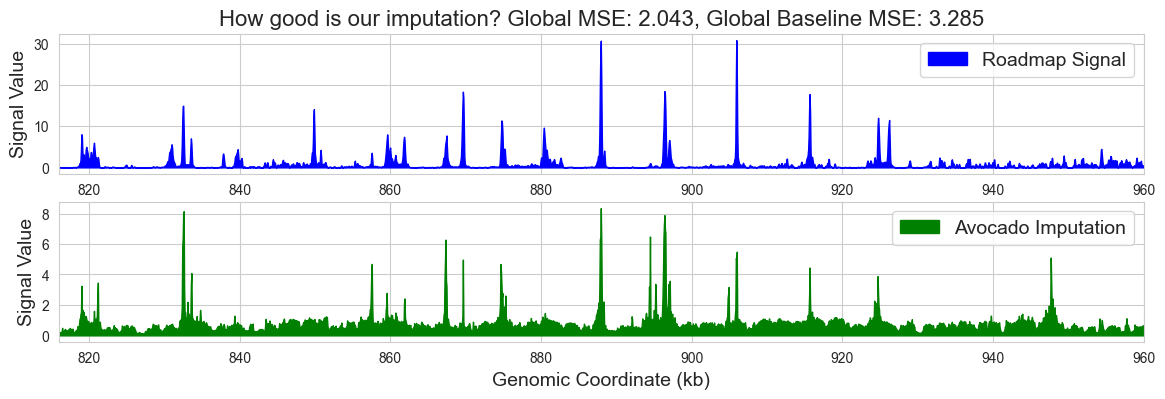

In [8]:
start, end = 12750, 15000
x = numpy.arange(start*64/1000., end*64/1000., 64/1000.)

mse_global = ((y_hat - y_true) ** 2).mean()
baseline_mse = ((y_true - y_true.mean()) ** 2).mean()

plt.figure(figsize=(14, 4))
plt.subplot(211)
plt.title("How good is our imputation? Global MSE: {:4.4}, Global Baseline MSE: {:4.4}".format(mse_global, baseline_mse), fontsize=16)
plt.fill_between(x, 0, y_true[start:end], color='b', label="Roadmap Signal")
plt.legend(fontsize=14)
plt.ylabel("Signal Value", fontsize=14)
#plt.ylim(0, 7)
plt.xlim(start*64/1000., end*64/1000.)

plt.subplot(212)
plt.fill_between(x, 0, y_hat[start:end], color='g', label="Avocado Imputation")
plt.legend(fontsize=14)
plt.ylabel("Signal Value", fontsize=14)
plt.xlabel("Genomic Coordinate (kb)", fontsize=14)
#plt.ylim(0, 7)
plt.xlim(start*64/1000., end*64/1000.)
plt.show()

In [15]:
numpy.load('/project/deeprna_data/avocado_data_trainingfolds/tissue_0_dnase.npy').shape

(5611520,)